# Prueba 4 - Simulación de Eventos Discretos

> Estudiante: Eduardo Zhizhpon <br/>
> Fecha: 25/07/2022

## Declaración de funciones y clases

In [26]:
import random
import simpy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

# Definición de clases

class Vehicle():
    def __init__(self, name, big_tonnage = False):
        self.name = name
        self.big_tonnage = big_tonnage
        self.fix = False
        self.day_fix = 0
        
        self.from_fix = 0
        
class Emov():
    def __init__(self, env):
        
        self.env = env
        self.big_tonnage_lane = simpy.Resource(self.env, BIG_TONNAGE_LANE_NUM)
        self.normal_tonnage_lane = simpy.Resource(self.env, NORMAL_TONNAGE_LANE_NUM)
        
        self.norm = stats.norm(MU, SIGMA)
        
        self.bernoulli_fix = stats.bernoulli(FIX_PROB)
        self.bernoulli_big_tonnage = stats.bernoulli(BIG_TONNAGE_PROB)
        
        self.vehicles_to_fix = []
        
    def get_parked_time(self):
        return random.randint(MIN_PACKED, MAX_PACKED)
    
    def get_ticket_time(self):
        return random.randint(MIN_TICKET, MAX_TICKET)
    
    def get_pay_license_plate_time(self):
        return random.randint(MIN_PAY_LICENSE_PLATE, 
                              MAX_PAY_LICENSE_PLATE)
    
    def get_revision_time(self):
        return abs(self.norm.rvs(1)[0])
    
    def make_fix(self):
        return abs(self.bernoulli_fix.rvs(1))
    
    def is_big_tonnage(self):
        return abs(self.bernoulli_big_tonnage.rvs(1))
    
    def get_paste_stamp_time(self):
        return random.randint(MIN_PASTE_STAMP, 
                              MAX_PASTE_STAMP)
    def get_out_time(self):
        return random.randint(MIN_OUT, 
                              MAX_OUT)
        
    def sim_process(self, vehicle):
        global approved_by_day, vehicles_approved_by_day, \
        process_time, process_time_by_day
        
        parked_time = self.get_parked_time()
        ticket_time = self.get_ticket_time()
        pay_license_plate_time = self.get_pay_license_plate_time()
        revision_time = self.get_revision_time()
        
        yield self.env.timeout(parked_time)
        yield self.env.timeout(ticket_time)
        yield self.env.timeout(pay_license_plate_time)
        yield self.env.timeout(revision_time)
        
        process_time += parked_time \
            + ticket_time \
            + pay_license_plate_time \
            + revision_time
        
        if self.make_fix() == 0:
            vehicle.fix = True
            vehicle.day_fix = self.env.now + get_minutes_from_day(2)
            vehicle.from_fix = self.env.now
            
            self.vehicles_to_fix.append(vehicle)
            
            if 'rejected' not in approved_by_day.keys():
                approved_by_day['rejected'] = 0
            approved_by_day['rejected'] += 1
        else:
            paste_stamp_time = self.get_paste_stamp_time()
            yield self.env.timeout(paste_stamp_time)
            process_time += paste_stamp_time
            
            if 'approved' not in approved_by_day.keys():
                approved_by_day['approved'] = 0
            approved_by_day['approved'] += 1
            
        out_time = self.get_out_time()
        yield self.env.timeout(out_time)
        process_time += out_time
        
        if self.env.now >= next_day:
            vehicles_approved_by_day[current_day] = approved_by_day
            approved_by_day = {}
            
            process_time_by_day[current_day] = process_time
            process_time = 0
        
# Funciones complementarias

def get_values_by_key(key, values):
    return [v[key] for k,v in values.items()]

def get_minutes_from_day(day):
    return 60 * 24 * day
    
def get_fixed_vehicle(emov):
    for i in range(len(emov.vehicles_to_fix)):
        if emov.vehicles_to_fix[i].day_fix <= emov.env.now:
            vehicle = emov.vehicles_to_fix.pop(i)
            vehicle.fix = False
            return vehicle
    return None
         
def arrival_vehicle(emov):
    global ticket, lane_by_day, \
        vehicles_lane_by_day, next_day, \
        current_day
    
    vehicle = None
    vehicle = get_fixed_vehicle(emov)
    
    if not vehicle:
        name = 'Vehicle ' + str(ticket)
        vehicle = Vehicle(name)

        if emov.is_big_tonnage() == 1:
            vehicle.big_tonnage = True
        ticket += 1
        
    if vehicle and vehicle.big_tonnage:
        with emov.big_tonnage_lane.request() as big_tonnage:
            yield big_tonnage
            yield env.process(emov.sim_process(vehicle))
            if 'big' not in lane_by_day.keys():
                lane_by_day['big'] = 0
            lane_by_day['big'] += 1
    else:
        with emov.normal_tonnage_lane.request() as normal_tonnage:
            yield normal_tonnage
            yield env.process(emov.sim_process(vehicle))
            if 'normal' not in lane_by_day.keys():
                lane_by_day['normal'] = 0
            lane_by_day['normal'] += 1
            
    if emov.env.now >= next_day:
        next_day = emov.env.now + get_minutes_from_day(1)
        vehicles_lane_by_day[current_day] = lane_by_day
        lane_by_day = {}
        current_day += 1
            
def start_sim(env):
    emov = Emov(env)
    
    while True:
        yield env.timeout(WAIT_TIME_TO_ARRIVAL)
        env.process(arrival_vehicle(emov))

## Ejecución de la simulación

In [38]:
# Variables constantes

BIG_TONNAGE_LANE_NUM = 1 # Cantidad de carriles para tonelaje grande
NORMAL_TONNAGE_LANE_NUM = 2 # Cantidad de carriles para tonelaje normal

MIN_PACKED = 3 # Tiempo mínimo de parqueo
MAX_PACKED = 5 # Tiempo máximo de parqueo

MIN_TICKET = 1 # Tiempo mínimo para obtener el ticket
MAX_TICKET = 3 # Tiempo máximo para obtener el ticket

MIN_PAY_LICENSE_PLATE = 5 # Tiempo mínimo para pagar la matrícula
MAX_PAY_LICENSE_PLATE = 10 # Tiempo máximo para pagar la matrícula

MIN_PASTE_STAMP = 1 # Tiempo mínimo para pegar la etiqueta
MAX_PASTE_STAMP = 3 # Tiempo máximo para pegar la etiqueta

MIN_OUT = 5 # Tiempo mínimo para salir
MAX_OUT = 10 # Tiempo máximo para salir

MU = 20 # Media de revisión
SIGMA = 10 # Desviación estándar para la revisión

FIX_PROB = 0.6 # Probabilidad de aceptar un vehículo sin arreglo

BIG_TONNAGE_PROB = 0.15 # Probabilidad de generar un vehículo de tonelaje grande

WAIT_TIME_TO_ARRIVAL = 3 # Tiempo de espera para generar vehículos

SIM_DAYS = 30 # Días de simulación

SIM_TIME = get_minutes_from_day(SIM_DAYS + 1) # Tiempo de simulación total


# Variables globales


current_day = 1 # Día de simulación

ticket = 0 # Número de ticket
next_day = get_minutes_from_day(1) # Para detectar cuando se termina el día

# Para almacenar los vehículos normales o de tonelaje grande
lane_by_day = {}
vehicles_lane_by_day = {}

# Para almacenar los vehículos aprobados o rechazados
approved_by_day = {}
vehicles_approved_by_day = {}

# Para almacenar el tiempo de proceso de la matrícula
process_time = 0
process_time_by_day = {}

# Inicio de la simulación
env = simpy.Environment()
env.process(start_sim(env))
env.run(until=SIM_TIME)
print('Simulación terminada')

Simulación terminada


## Gráficas de los resultados

**Cantidad de vehículos de tonelaje normal o grande por día**

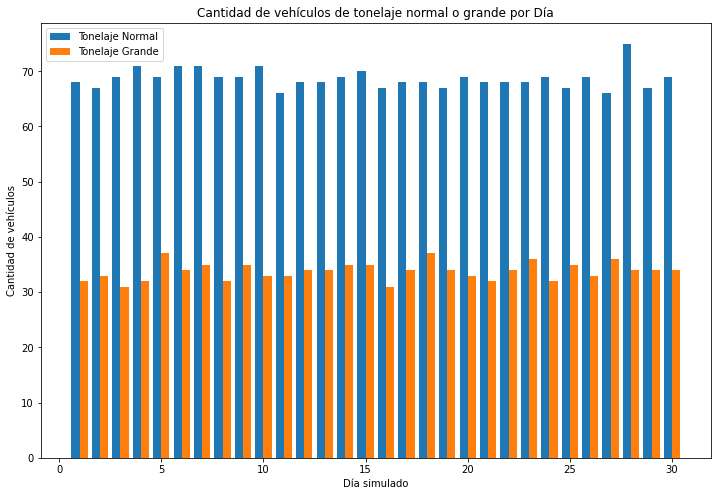

In [42]:
y_normal = get_values_by_key('normal', vehicles_lane_by_day)
y_big = get_values_by_key('big', vehicles_lane_by_day)
x = np.array(list(vehicles_lane_by_day.keys()))

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(x - 0.2, y_normal, 0.4, label='Tonelaje Normal')
ax.bar(x + 0.2, y_big, 0.4, label='Tonelaje Grande')
ax.set_xlabel('Día simulado')
ax.set_ylabel('Cantidad de vehículos')
ax.set_title('Cantidad de vehículos de tonelaje normal o grande por Día')
plt.legend(['Tonelaje Normal', 'Tonelaje Grande'])
plt.show()

**Porcentaje de vehículos aceptados o rechazados por día**

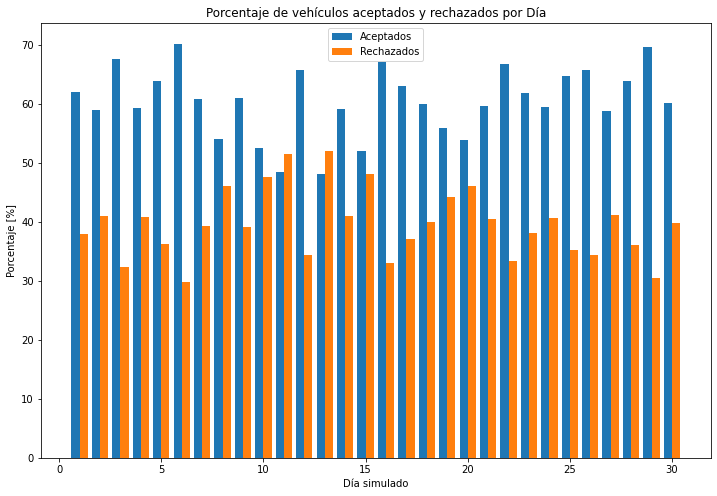

In [45]:
y_approved = get_values_by_key('approved', vehicles_approved_by_day)
y_rejected = get_values_by_key('rejected', vehicles_approved_by_day)
for i in range(len(y_approved)):
    total = y_approved[i] + y_rejected[i]
    y_approved[i] = (y_approved[i] * 100) / total
    y_rejected[i] = (y_rejected[i] * 100) / total
    
x = np.array(list(vehicles_approved_by_day.keys()))

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(x - 0.2, y_approved, 0.4)
ax.bar(x + 0.2, y_rejected, 0.4)
ax.set_xlabel('Día simulado')
ax.set_ylabel('Porcentaje [%]')
ax.set_title('Porcentaje de vehículos aceptados y rechazados por Día')
plt.legend(['Aceptados', 'Rechazados'])
plt.show()

**Tiempo del proceso de matriculación de vehículos por día**

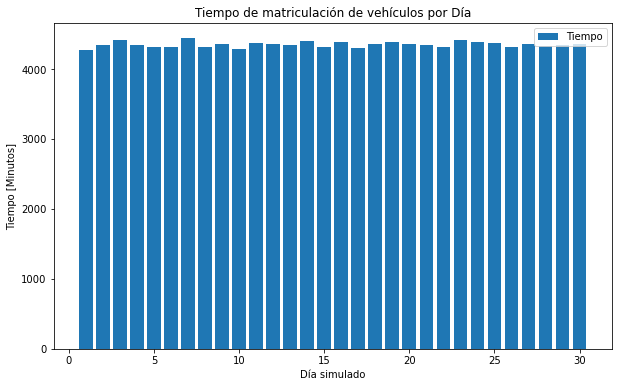

In [46]:
x = list(process_time_by_day.keys())
y_process = list(process_time_by_day.values())

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, y_process)
ax.set_xlabel('Día simulado')
ax.set_ylabel('Tiempo [Minutos]')
ax.set_title('Tiempo de matriculación de vehículos por Día')
plt.legend(['Tiempo'])
plt.show()